# Goals of this notebook
- Build flax.linen or flax.nnx modules for the EPIC-EIC architecture.
- This involves making modules for the core with trainable weights, slots with inputs, and lookup tables (LUTs) with non-trainable inter-core connectivity $\{-1, 0, 1\}$


## Summarizing the Connectivity patterns

We have the following:
1. rows and columns
2. cores
3. i/o slots
4. neighbors to all the cores
5. per slot there are neurons. Does that mean that the neurons only exist at the slots?

## Connectivity pattern
1. Cores that share a row and/or a column are connected. Tensor $C$ specifies these cores.
   1. e.g. $C[1, 1, 1, 2]$ represents if the cores present on row 1, col 1 and row 1, col 2 are connected. They are!
2. Each core has some number of neighbors. This number depends on perhaps where the core is located -- centrally located cored will have more neighbors.
   1. The tensor $N$ contains this info. It contains a linearly intexed list (0 to num_cores-1) and number of neighbors it has.
   2. e.g. $N[3, 2] = 2$ represents that there are $3$ cores with exactly $2$ neighbors.
3. The tensor $S$ determines how the cores can talk to each other. It describes how the slots are connected
   1. $S$ specifices how a core at a given row and column is connected to one of its neighbors through which i/o slots
   2. e.g. $S[1, 2, 3, 4, 1] = 1$ would imply that the core sitting at row 1, column 2, is connected to its neighbor #4, at the input slot #3 via its output slot #1 (verify this with Johannes). The 1 represents that such a connection exists.
4. Finally $W$ is the tensor containing all the weights. To find a weight between two neuron.

## Modules needed
1. Core module: with $256 \times 256$ weights.
2. Input Slot module: can accept a signed input vector. Each core should have 4 of these
3. Output slot module: vector - matrix multiplication ($64 \times 64$ weight $64 \times 1$ input vector) -- Not sure if this needs to be imp,emented explicitly!
4. Slot LUT module: For each input module, determine which core can send inputs.
5. External input module: Module that can provide external inputs to the cores. -- Does this need to be included in the Input Slot module

## Design
1. Make a module for the core. For every core initialize $256 \times 256$ weights. Each core should receive an input vector that is $256$ elements wide. This vector is stitched together from inputs from previous layer or external inputs.
2. Make a module for slots... TBD

In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import flax
from flax import linen as nn
from flax import nnx
import optax
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
from collections import defaultdict

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

In [2]:
## define binary thresholding function: states [0, 1]
def binary_activation(x, threshold, noise_sd, key):
    """
    Binary activation function
    """
    # key, key2 = jax.random.split(key, 2)

    # generate noise
    noise = jax.random.normal(key, shape = x.shape) * noise_sd

    # inject noise
    x = x + noise

    s = jnp.where(
        x < threshold, 0.0, 1.0
    )

    return s

## helper function
@jax.jit
def gaussian_cdf(x, mu, sigma):
    return jax.scipy.stats.norm.cdf(x, loc = mu, scale = sigma)

@jax.jit
def gaussian_pdf(x, mu, sigma):
    return jax.scipy.stats.norm.pdf(x, loc = mu, scale = sigma)

@jax.jit
def expected_state(x, thresholds, noise_sd):
    t1, t2 = thresholds
    e = ((1 - gaussian_cdf(x = t2 - x, mu = 0, sigma = noise_sd)) - gaussian_cdf(x = t1 - x, mu = 0, sigma = noise_sd))
    return e


## cuatom gradient for binary activation
@jax.custom_vjp
def custom_binary_gradient(x, threshold, noise_sd, key):
    return binary_activation(x = x, threshold = threshold, noise_sd = noise_sd, key = key)

def custom_binary_gradient_fwd(x, threshold, noise_sd, key):
    return custom_binary_gradient(x, threshold, noise_sd, key), (x, threshold, noise_sd)

def custom_binary_gradient_bwd(residuals, gradients):
    x, threshold, noise_sd = residuals
    grad = gaussian_pdf(x = x - threshold, mu = 0, sigma = noise_sd)
    return (grad*gradients, None, None, None)

custom_binary_gradient.defvjp(custom_binary_gradient_fwd, custom_binary_gradient_bwd)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

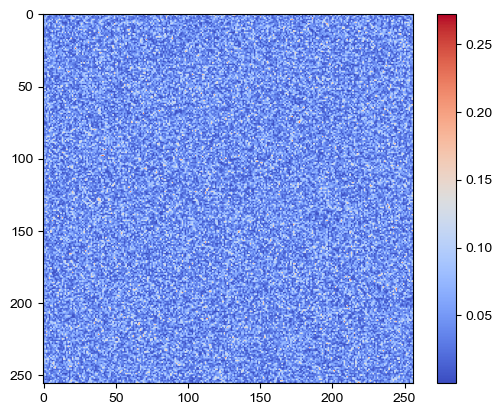

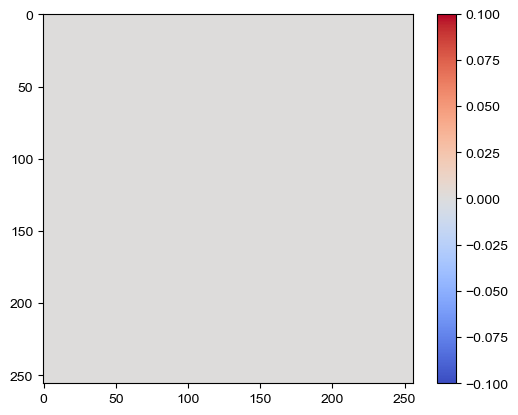

In [29]:
## define the core module
class Core(nnx.Module):
    """
    Defines a core module with binary activation function
    """

    def __init__(self,
                 key: jax.random.key,
                 weight_matrix_size: int = 256,
                 input_vector_size: int = 256,
                 threshold: float = 0.0,
                 noise_sd: float = 0.1
                 ):
        
        self.weight_matrix_size = weight_matrix_size
        self.input_vector_size = input_vector_size
        self.threshold = threshold
        self.noise_sd = noise_sd
        self.key = key

        assert self.weight_matrix_size == self.input_vector_size, "Weight matrix dimension must match input vector size"


        # initialize weights
        weights_ = jax.random.normal(key=key, shape=(self.weight_matrix_size, self.weight_matrix_size))

        # make sure that the weights are positive
        weights_ = jnp.abs(weights_)

        # assign the parameters trainable
        self.weights = nnx.Param(weights_ * jnp.sqrt(1/self.input_vector_size))

        ## We don't have a bias term as of now

    def __call__(self, x):
        """
        Forward pass.
        x = Wx
        x = custom_binary_gradient(x)
        """

        # assert len(x) == self.input_vector_size, "Input vector size must match the size of the input vector"

        x = jnp.dot(self.weights.value, x)
        key, split_key = jax.random.split(self.key, 2)
        x = custom_binary_gradient(x, self.threshold, self.noise_sd, key)
        return x
    

## testing ##
ex_x = jnp.arange(256).astype(float)
print(ex_x)
ex_key = jax.random.key(0)
c1 = Core(key = ex_key)
out = c1(ex_x)
print(out)
ex_tar = jax.random.randint(key = ex_key, shape = (256,), minval = 0, maxval = 2)
ex_tar = jnp.array(ex_tar).astype(float)

plt.figure()
plt.imshow(c1.weights.value, cmap = 'coolwarm')
plt.colorbar()

## loss function
def loss_fn(weights):
    c1.weights = nnx.Param(weights)
    preds = c1(ex_x)
    loss = jnp.mean((preds - ex_tar)**2)
    return loss

ex_grads = jax.grad(loss_fn)(c1.weights.value)
print(ex_grads.shape)


plt.figure()
plt.imshow(ex_grads.reshape(-1, 256), cmap = 'coolwarm')
plt.colorbar()


## Input slot module
Try out a few different options

### Option 1:
- Build an input slot and a LUT per slot.
- Split the input slot into positive and negative parts
- Combine all the $16 \times 64$ vectors into one and then perform matrix-vector product.
- Keeping the core id int for now. The idea is to linearize the core numbers.

### Option 2
- Combine all input slots into one vector of size $256$.
- This would require the LUT module to stitch together multiple inputs to be fed into the input.


In [ ]:
## approach 1
class InputSlotSingle(nnx.Module):

    def __init__(self,
                 lut : jnp.ndarray,
                 pos_vecs : jnp.ndarray,
                 neg_vecs : jnp.ndarray,
                 slot_id : int,
                 core_row_idx : int,
                 core_col_idx : int,
                 sender_row_idx: int,
                 sender_col_idx: int,
                 sender_slot_idx: int):
        
        self.lut = lut
        self.pos_vecs = pos_vecs
        self.neg_vecs = neg_vecs
        self.slot_id = slot_id
        self.core_row_idx = core_row_idx
        self.core_col_idx = core_col_idx
        self.sender_row_idx = sender_row_idx
        self.sender_col_idx = sender_col_idx
        self.sender_slot_idx = sender_slot_idx

    @staticmethod
    def is_connected(
        core_row_idx: int,
        core_col_idx: int,
        sender_row_idx: int,
        sender_col_idx: int):

        if core_row_idx == sender_row_idx or core_col_idx == sender_col_idx:
            return True
        else:
            return False
        

class LUT(nnx.Module):

    def __init__(self, 
                 receiver_row_idx: int,
                 receiver_col_idx: int,
                 receiver_slot_idx: int,
                 sender_row_idx: int,
                 sender_col_idx: int,
                 sender_output_slot_idx: int,
                 num_neighbors: int = 31):
        
        self.receiver_row_idx = receiver_row_idx
        self.receiver_col_idx = receiver_col_idx
        self.receiver_slot_idx = receiver_slot_idx
        self.num_neighbors = num_neighbors
        self.sender_row_idx = sender_row_idx
        self.sender_col_idx = sender_col_idx
        self.sender_output_slot_idx = sender_output_slot_idx

        self.lut = jnp.zeros((num_neighbors-1, 7)) # columns represent: [sender_row, sender_col, sender_slot, receiver_row, receiver_col, receiver_slot, weight]

        ## initialize the last column with +1/-1 

    
        
        
        



    
        
